<a href="https://colab.research.google.com/github/zachzander/object_detection/blob/main/object_detection2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import zipfile
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"zainabzaiba","key":"44b96ac8c9180153e7631b345f55f497"}'}

In [ ]:
# Kaggle API setup
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download existing Kaggle dataset
!kaggle datasets download -d christianvorhemus/industrial-quality-control-of-packages

# Download custom dataset
!kaggle datasets download -d zainabzaiba/object-detection

# Extract datasets
import zipfile

# Extract Kaggle dataset
zip_ref = zipfile.ZipFile('/content/industrial-quality-control-of-packages.zip', 'r')
zip_ref.extractall('/content/datasets/kaggle')
zip_ref.close()

# Extract custom dataset
zip_ref = zipfile.ZipFile('/content/object-detection.zip', 'r')
zip_ref.extractall('/content/datasets/custom')
zip_ref.close()


Dataset URL: https://www.kaggle.com/datasets/christianvorhemus/industrial-quality-control-of-packages
License(s): GPL-2.0
industrial-quality-control-of-packages.zip: Skipping, found more recently modified local copy (use --force to force download)
Dataset URL: https://www.kaggle.com/datasets/zainabzaiba/object-detection
License(s): unknown
object-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Step 2: Load and Combine Datasets

import os
import cv2
import numpy as np
from sklearn.utils import shuffle

def load_images(base_path, categories, img_size=300, limit=None):
    data = []

    for category in categories:
        folder = os.path.join(base_path, category)
        if not os.path.exists(folder):
            print(f"Directory {folder} does not exist.")
            continue

        label = 0 if 'intact' in category else 1

        files = os.listdir(folder)
        if limit:
            files = files[:limit // 4]  # Limit per category

        for img_name in files:
            img_path = os.path.join(folder, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (img_size, img_size))
                data.append([img, label])
            else:
                print(f"Failed to load image: {img_path}")

    return shuffle(data, random_state=42)

In [ ]:
# Define categories for both datasets
kaggle_categories = ['intact/side', 'intact/top', 'damaged/side', 'damaged/top']
custom_categories = ['defect_side', 'defect_top', 'intact_side', 'intact_top']


In [ ]:
# Load Kaggle dataset (limit to 400 images)
kaggle_data = load_images('/content/datasets/kaggle', kaggle_categories, limit=400)

In [ ]:
import os

# List the contents of the Kaggle dataset directory
kaggle_dir = '/content/datasets/kaggle'
for root, dirs, files in os.walk(kaggle_dir):
    print(root)
    for name in dirs:
        print(os.path.join(root, name))
    for name in files:
        print(os.path.join(root, name))


/content/datasets/kaggle
/content/datasets/kaggle/intact
/content/datasets/kaggle/damaged
/content/datasets/kaggle/intact
/content/datasets/kaggle/intact/top
/content/datasets/kaggle/intact/side
/content/datasets/kaggle/intact/top
/content/datasets/kaggle/intact/top/0872030545745_top.png
/content/datasets/kaggle/intact/top/0637145699424_top.png
/content/datasets/kaggle/intact/top/0843791760826_top.png
/content/datasets/kaggle/intact/top/0481852146417_top.png
/content/datasets/kaggle/intact/top/0700097671588_top.png
/content/datasets/kaggle/intact/top/0567183484805_top.png
/content/datasets/kaggle/intact/top/0681342689666_top.png
/content/datasets/kaggle/intact/top/0689604931304_top.png
/content/datasets/kaggle/intact/top/0555795810016_top.png
/content/datasets/kaggle/intact/top/0562047801759_top.png
/content/datasets/kaggle/intact/top/0307016307115_top.png
/content/datasets/kaggle/intact/top/0927720374404_top.png
/content/datasets/kaggle/intact/top/0251909608388_top.png
/content/datase

In [ ]:
import os

# List the contents of the Kaggle dataset directory
kaggle_dir = '/content/datasets/custom'
for root, dirs, files in os.walk(kaggle_dir):
    print(root)
    for name in dirs:
        print(os.path.join(root, name))
    for name in files:
        print(os.path.join(root, name))


In [ ]:
# Load custom dataset (all images)
custom_data = load_images('/content/datasets/custom', custom_categories)


In [ ]:
# Combine datasets
all_data = kaggle_data + custom_data

In [ ]:
# Shuffle the combined dataset
all_data = shuffle(all_data, random_state=42)

In [ ]:
# Split into features and labels
X = np.array([item[0] for item in all_data], dtype='float32') / 255.0
y = np.array([item[1] for item in all_data])

In [ ]:
# Convert labels to categorical
y = tf.keras.utils.to_categorical(y, num_classes=2)

In [ ]:
# Step 3: Data Augmentation

#from tensorflow.keras.preprocessing.image import ImageDataGenerator

#datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )


In [ ]:
# Fit the generator to your data
#datagen.fit(X)

In [ ]:
# Step 4: Data Splitting

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
# Step 5: Model Training with Class Weights

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight


In [ ]:
# Load ResNet50 without top classification layer
base_model = ResNet50(weights='imagenet', include_top=False)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)  # Output layer with 2 classes: intact or damaged


In [ ]:
# Create model
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Compile model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(y, axis=1)), y=np.argmax(y, axis=1))
class_weights = dict(enumerate(class_weights))

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_val, y_val),
    class_weight=class_weights
)



Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 202s 15s/step - accuracy: 0.4932 - loss: 2.1180 - val_accuracy: 0.5000 - val_loss: 0.7630
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 204s 15s/step - accuracy: 0.4635 - loss: 1.0724 - val_accuracy: 0.5000 - val_loss: 0.7884
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 193s 15s/step - accuracy: 0.5312 - loss: 0.7312 - val_accuracy: 0.5000 - val_loss: 0.7139
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 181s 14s/step - accuracy: 0.5272 - loss: 0.6958 - val_accuracy: 0.5000 - val_loss: 0.7062
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 213s 15s/step - accuracy: 0.4538 - loss: 0.6964 - val_accuracy: 0.4800 - val_loss: 0.6935
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 197s 15s/step - accuracy: 0.5310 - loss: 0.6985 - val_accuracy: 0.5000 - val_loss: 0.7133
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 188s 15s/step - accuracy: 0.5020 - loss: 0.7141 - val_accuracy: 0.5000 - val_loss: 0.7045
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 204s 15s/step - accuracy: 0.5176 - loss: 0.7050 - val_accuracy: 0.

In [ ]:
# Step 6: Evaluation

val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 43s 11s/step - accuracy: 0.5167 - loss: 0.7402
Validation Loss: 0.7565786838531494
Validation Accuracy: 0.5


In [ ]:
# Step 7: Fine-tuning
# Unfreeze some layers of the base model
for layer in base_model.layers[-10:]:
    layer.trainable = True

In [ ]:
# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Continue training
history_fine = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_val, y_val),
    class_weight=class_weights
)



Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 222s 16s/step - accuracy: 0.5091 - loss: 0.7027 - val_accuracy: 0.5000 - val_loss: 0.7255
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 262s 16s/step - accuracy: 0.6370 - loss: 0.6580 - val_accuracy: 0.5000 - val_loss: 0.7108
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 262s 16s/step - accuracy: 0.6531 - loss: 0.6454 - val_accuracy: 0.5000 - val_loss: 0.6985
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 262s 16s/step - accuracy: 0.6652 - loss: 0.6198 - val_accuracy: 0.4900 - val_loss: 0.6878
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 258s 16s/step - accuracy: 0.6324 - loss: 0.6267 - val_accuracy: 0.5500 - val_loss: 0.6813
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 201s 16s/step - accuracy: 0.6791 - loss: 0.6030 - val_accuracy: 0.5500 - val_loss: 0.6776
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 207s 16s/step - accuracy: 0.6969 - loss: 0.5924 - val_accuracy: 0.5400 - val_loss: 0.6753
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 254s 15s/step - accuracy: 0.6953 - loss: 0.5890 - val_accuracy: 0.

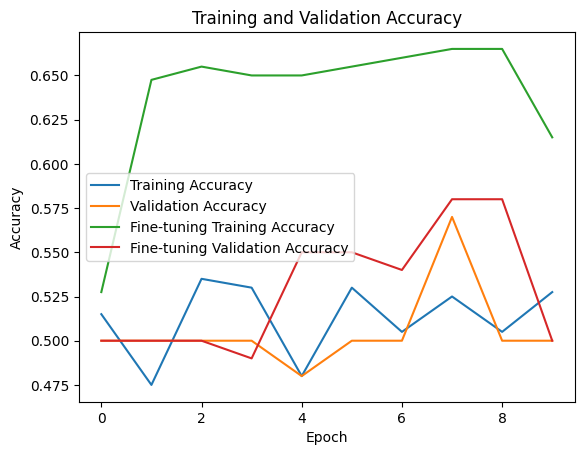

In [ ]:
# Plot accuracy and validation accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_fine.history['accuracy'], label='Fine-tuning Training Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Fine-tuning Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


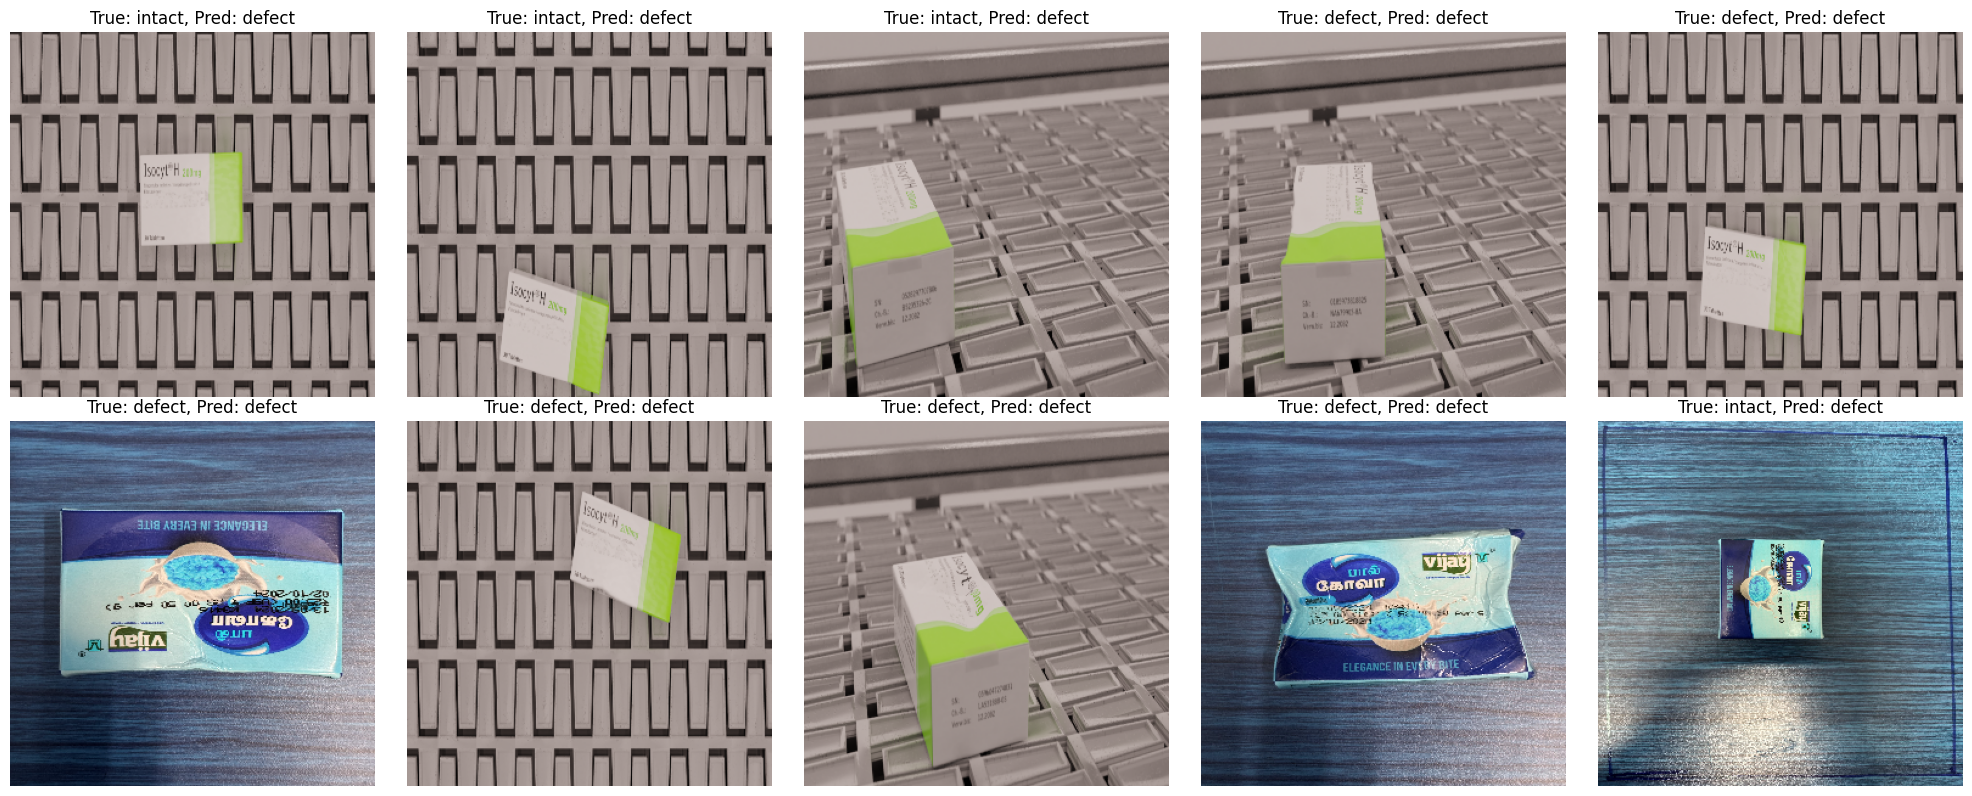

In [ ]:
# Step 8: Make Predictions and Plot Results

# Define label mapping
label_mapping = {0: 'intact', 1: 'defect'}

# Select a few samples from the validation set
sample_indices = np.random.choice(len(X_val), 10, replace=False)
sample_images = X_val[sample_indices]
sample_labels = y_val[sample_indices]

# Make predictions
predictions = model.predict(sample_images)

# Plot the results
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for img, ax, true_label, pred in zip(sample_images, axes, sample_labels, predictions):
    ax.imshow(img)
    true_class = label_mapping[np.argmax(true_label)]
    pred_class = label_mapping[np.argmax(pred)]
    ax.set_title(f'True: {true_class}, Pred: {pred_class}')
    ax.axis('off')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


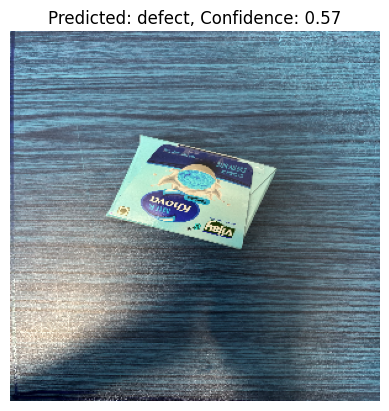

In [ ]:
import numpy as np
import cv2
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

def load_and_preprocess_image(img_path, img_size=300):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Image not found or unable to load: {img_path}")
    img = cv2.resize(img, (img_size, img_size))
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

def make_prediction(model, img_path):
    img = load_and_preprocess_image(img_path)
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction, axis=1)[0]
    confidence = np.max(prediction, axis=1)[0]
    return predicted_class, confidence, img[0]

# Define label mapping
label_mapping = {0: 'intact', 1: 'defect'}

# Example usage
img_path = '/content/datasets/custom/intact_top/image_18.png'  # Change to an existing image
try:
    predicted_class, confidence, processed_img = make_prediction(model, img_path)
    predicted_label = label_mapping[predicted_class]

    # Plot the image with the predicted label
    plt.imshow(processed_img)
    plt.title(f'Predicted: {predicted_label}, Confidence: {confidence:.2f}')
    plt.axis('off')
    plt.show()
except ValueError as e:
    print(e)


4/4 ━━━━━━━━━━━━━━━━━━━━ 39s 9s/step


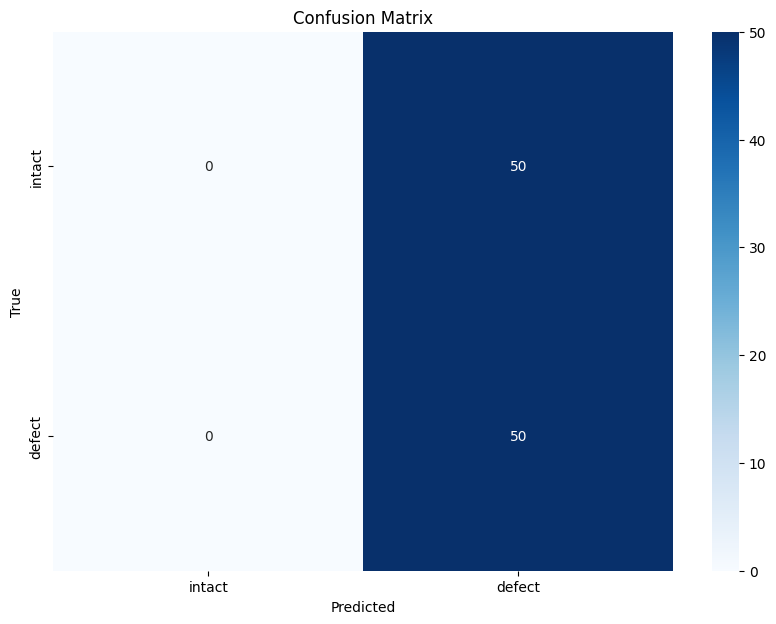

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Make predictions on the validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['intact', 'defect'], yticklabels=['intact', 'defect'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 894ms/step


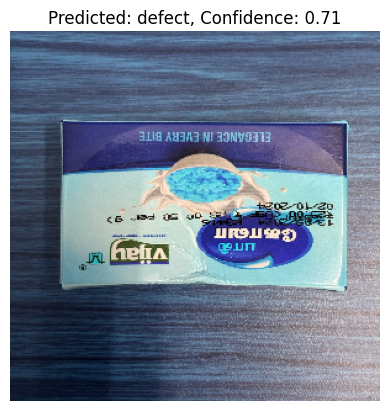

In [ ]:
import numpy as np
import cv2
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

def load_and_preprocess_image(img_path, img_size=300):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Image not found or unable to load: {img_path}")
    img = cv2.resize(img, (img_size, img_size))
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

def make_prediction(model, img_path):
    img = load_and_preprocess_image(img_path)
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction, axis=1)[0]
    confidence = np.max(prediction, axis=1)[0]
    return predicted_class, confidence, img[0]

# Define label mapping
label_mapping = {0: 'intact', 1: 'defect'}

# Example usage
img_path = '/content/datasets/custom/defect_top/image_2.png'  # Change to an existing image
try:
    predicted_class, confidence, processed_img = make_prediction(model, img_path)
    predicted_label = label_mapping[predicted_class]

    # Plot the image with the predicted label
    plt.imshow(processed_img)
    plt.title(f'Predicted: {predicted_label}, Confidence: {confidence:.2f}')
    plt.axis('off')
    plt.show()
except ValueError as e:
    print(e)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 850ms/step


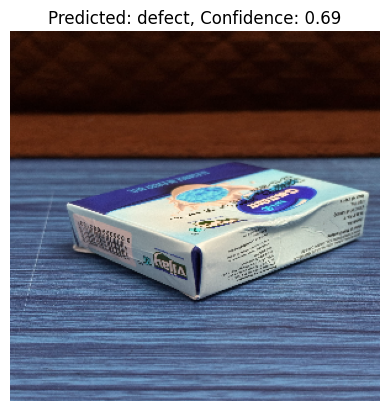

In [ ]:
import numpy as np
import cv2
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

def load_and_preprocess_image(img_path, img_size=300):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Image not found or unable to load: {img_path}")
    img = cv2.resize(img, (img_size, img_size))
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

def make_prediction(model, img_path):
    img = load_and_preprocess_image(img_path)
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction, axis=1)[0]
    confidence = np.max(prediction, axis=1)[0]
    return predicted_class, confidence, img[0]

# Define label mapping
label_mapping = {0: 'intact', 1: 'defect'}

# Example usage
img_path = '/content/datasets/custom/defect_side/image_2.png'  # Change to an existing image
try:
    predicted_class, confidence, processed_img = make_prediction(model, img_path)
    predicted_label = label_mapping[predicted_class]

    # Plot the image with the predicted label
    plt.imshow(processed_img)
    plt.title(f'Predicted: {predicted_label}, Confidence: {confidence:.2f}')
    plt.axis('off')
    plt.show()
except ValueError as e:
    print(e)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


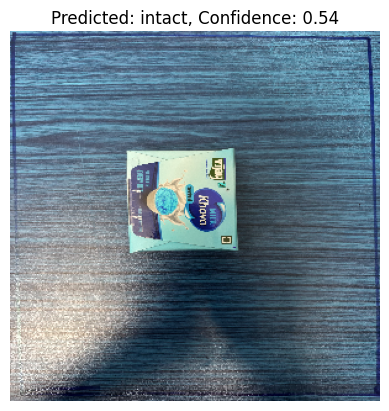

In [ ]:
import numpy as np
import cv2
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

def load_and_preprocess_image(img_path, img_size=300):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Image not found or unable to load: {img_path}")
    img = cv2.resize(img, (img_size, img_size))
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

def make_prediction(model, img_path):
    img = load_and_preprocess_image(img_path)
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction, axis=1)[0]
    confidence = np.max(prediction, axis=1)[0]
    return predicted_class, confidence, img[0]

# Define label mapping
label_mapping = {0: 'intact', 1: 'defect'}

# Example usage
img_path = '/content/datasets/custom/intact_top/image_5.png'  # Change to an existing image
try:
    predicted_class, confidence, processed_img = make_prediction(model, img_path)
    predicted_label = label_mapping[predicted_class]

    # Plot the image with the predicted label
    plt.imshow(processed_img)
    plt.title(f'Predicted: {predicted_label}, Confidence: {confidence:.2f}')
    plt.axis('off')
    plt.show()
except ValueError as e:
    print(e)


In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Step 2: Set up checkpoint directory
checkpoint_dir = '/content/drive/My Drive/checkpoints'

In [ ]:
# Step 3: Save the model checkpoint manually after executing all cells
model.save(checkpoint_dir + '/final_model.h5')

In [ ]:
# Print model summary to verify loading
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, None, None, 3)  │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, None, None, 64) │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, None, None, 64) │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, None, None, 64) │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, None, None, 64) │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, None, None, 64) │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, None, None, 64) │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, None, None, 64) │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, None, None, 64) │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, None, None, 64) │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, None, None, 64) │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, None, None, 64) │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, None, None,     │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, None, None,     │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 38,819,720 (148.09 MB)

 Trainable params: 6,565,890 (25.05 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

 Optimizer params: 13,131,782 (50.09 MB)

In [ ]:
!pip install opencv-python-headless
!pip install tensorflow


In [ ]:
import cv2

# Capture video feed from Continuity Camera
cap = cv2.VideoCapture(0)  # 0 is usually the default camera

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Display the frame
    cv2.imshow('Continuity Camera Feed', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [ ]:
#Capture Video Feed
import cv2

# Try different camera indices
for i in range(3):
    cap = cv2.VideoCapture(i)
    if cap.isOpened():
        print(f"Camera index {i} opened successfully.")
        break
else:
    print("Error: Could not open any camera.")
    cap.release()
    exit()

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to capture image")
        break

    # Display the frame
    cv2.imshow('Continuity Camera Feed', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Error: Could not open any camera.
Failed to capture image


In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np

def capture_image():
    js = Javascript('''
        async function captureImage() {
            const video = document.createElement('video');
            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            video.srcObject = stream;
            await new Promise((resolve) => video.onloadedmetadata = resolve);
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getTracks().forEach(track => track.stop());
            return canvas.toDataURL('image/jpeg', 0.8);
        }
        captureImage();
    ''')
    display(js)
    data = eval_js('captureImage()')
    #Change is on the line below. Access the element at index 1 of the list returned by data.split(',')
    binary = b64decode(data.split(',')[1])
    img = np.frombuffer(binary, dtype=np.uint8)
    img = cv2.imdecode(img, cv2.IMREAD_COLOR)
    return img

img = capture_image()
cv2.imwrite('captured_image.jpg', img)

<IPython.core.display.Javascript object>

True

In [ ]:
import cv2

# Capture video from the default webcam
cap = cv2.VideoCapture(0)  # 0 for the default webcam


In [ ]:
def preprocess_frame(frame, img_size=300):
    frame = cv2.resize(frame, (img_size, img_size))
    frame = frame.astype('float32') / 255.0
    frame = np.expand_dims(frame, axis=0)  # Add batch dimension
    return frame


In [ ]:
########
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
##########
from tensorflow.keras.models import load_model

# Load the model
model_path = '/content/drive/My Drive/checkpoints/final_model.h5'
model = load_model(model_path)

# Verify the model is loaded
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, None, None, 3)  │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, None, None, 64) │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, None, None, 64) │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, None, None, 64) │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, None, None, 64) │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, None, None, 64) │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, None, None, 64) │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, None, None, 64) │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, None, None, 64) │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, None, None, 64) │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, None, None, 64) │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, None, None, 64) │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, None, None,     │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, None, None,     │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 25,687,940 (97.99 MB)

 Trainable params: 6,565,890 (25.05 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

 Optimizer params: 2 (12.00 B)

In [ ]:
######
import numpy as np
import tensorflow as tf
# Load the TensorFlow Lite model
model_path = '/content/drive/My Drive/checkpoints/final_model.tflite'
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

In [ ]:
########
import tensorflow as tf
import cv2
import numpy as np
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the checkpoint directory
checkpoint_dir = '/content/drive/My Drive/checkpoints'

# Load the Keras model
keras_model_path = checkpoint_dir + '/final_model.h5'
keras_model = tf.keras.models.load_model(keras_model_path)

# Print Keras model summary to verify loading
keras_model.summary()

# Load the TensorFlow Lite model
tflite_model_path = checkpoint_dir + '/final_model.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Get input and output tensors for TensorFlow Lite model
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Print input and output details to verify loading
print("TensorFlow Lite model input details:", input_details)
print("TensorFlow Lite model output details:", output_details)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, None, None, 3)  │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, None, None, 64) │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, None, None, 64) │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, None, None, 64) │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, None, None, 64) │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, None, None, 64) │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, None, None, 64) │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, None, None, 64) │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, None, None, 64) │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, None, None, 64) │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, None, None, 64) │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, None, None, 64) │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, None, None,     │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, None, None,     │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 25,687,940 (97.99 MB)

 Trainable params: 6,565,890 (25.05 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

 Optimizer params: 2 (12.00 B)

TensorFlow Lite model input details: [{'name': 'serving_default_input_layer_1:0', 'index': 0, 'shape': array([1, 1, 1, 3], dtype=int32), 'shape_signature': array([-1, -1, -1,  3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
TensorFlow Lite model output details: [{'name': 'StatefulPartitionedCall_1:0', 'index': 189, 'shape': array([1, 2], dtype=int32), 'shape_signature': array([-1,  2], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


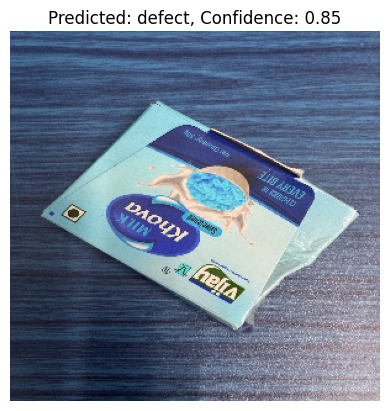

In [ ]:
#######
import numpy as np
import cv2
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

def load_and_preprocess_image(img_path, img_size=300):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Image not found or unable to load: {img_path}")
    img = cv2.resize(img, (img_size, img_size))
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

def make_prediction(model, img_path):
    img = load_and_preprocess_image(img_path)
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction, axis=1)[0]
    confidence = np.max(prediction, axis=1)[0]
    return predicted_class, confidence, img[0]

# Define label mapping
label_mapping = {0: 'intact', 1: 'defect'}

# Example usage
img_path = '/content/datasets/custom/defect_top/image_20.png'  # Change to an existing image
try:
    predicted_class, confidence, processed_img = make_prediction(model, img_path)
    predicted_label = label_mapping[predicted_class]

    # Plot the image with the predicted label
    plt.imshow(processed_img)
    plt.title(f'Predicted: {predicted_label}, Confidence: {confidence:.2f}')
    plt.axis('off')
    plt.show()
except ValueError as e:
    print(e)


In [ ]:
import os

directory = '/content/drive/My Drive/checkpoints'
files = os.listdir(directory)
print(files)

['final_model1.h5', 'final_model.h5', 'final_model.tflite']


TensorFlow Lite model input details: [{'name': 'serving_default_input_layer_1:0', 'index': 0, 'shape': array([1, 1, 1, 3], dtype=int32), 'shape_signature': array([-1, -1, -1,  3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


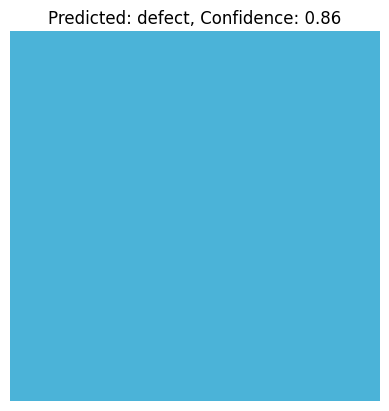

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Print input details to verify the expected shape
print("TensorFlow Lite model input details:", input_details)

def preprocess_image(img_path, img_size=1): # Changed img_size to 1
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Image not found or unable to load: {img_path}")
    img = cv2.resize(img, (img_size, img_size))  # Resize to 1x1 pixel
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

def make_prediction_tflite(interpreter, img_path):
    img = preprocess_image(img_path)
    interpreter.set_tensor(input_details[0]['index'], img)
    interpreter.invoke()
    # Access the 'index' key within the first dictionary of the output_details list
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predicted_class = np.argmax(output_data, axis=1)
    confidence = np.max(output_data, axis=1)
    return predicted_class, confidence, img[0] # Remove extra dimension

# Define label mapping
label_mapping = {0: 'intact', 1: 'defect'}

# Example usage
img_path = '/content/datasets/custom/defect_top/image_20.png'  # Change to an existing image
try:
    predicted_class, confidence, processed_img = make_prediction_tflite(interpreter, img_path)
    # Extract the class value as an integer from the NumPy array
    predicted_class = int(predicted_class[0])
    predicted_label = label_mapping[predicted_class]

    # Extract the confidence value from the NumPy array
    confidence = confidence[0]

    # Plot the image with the predicted label
    plt.imshow(processed_img)
    plt.title(f'Predicted: {predicted_label}, Confidence: {confidence:.2f}')
    plt.axis('off')
    plt.show()
except ValueError as e:
    print(e)

In [ ]:
#########
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Print input details to verify the expected shape
print("TensorFlow Lite model input details:", input_details)

def preprocess_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Image not found or unable to load: {img_path}")
    img = cv2.resize(img, (1, 1))  # Resize to 1x1 pixel as per model input
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

def make_prediction_tflite(interpreter, img_path):
    img = preprocess_image(img_path)
    interpreter.set_tensor(input_details[0]['index'], img)
    interpreter.invoke()
    # Access the 'index' key within the first dictionary of the output_details list
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predicted_class = np.argmax(output_data, axis=1)
    confidence = np.max(output_data, axis=1)
    return predicted_class, confidence

# Define label mapping
label_mapping = {0: 'intact', 1: 'defect'}

# Example usage
img_path = '/content/datasets/custom/defect_top/image_20.png'  # Change to an existing image
try:
    predicted_class, confidence = make_prediction_tflite(interpreter, img_path)
    # Extract the class value as an integer from the NumPy array
    predicted_class = int(predicted_class[0])
    predicted_label = label_mapping[predicted_class]

    # Extract the confidence value from the NumPy array
    confidence = confidence[0]

    # Display the prediction
    print(f'Predicted: {predicted_label}, Confidence: {confidence:.2f}')

except ValueError as e:
    print(e)

TensorFlow Lite model input details: [{'name': 'serving_default_input_layer_1:0', 'index': 0, 'shape': array([1, 1, 1, 3], dtype=int32), 'shape_signature': array([-1, -1, -1,  3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Predicted: defect, Confidence: 0.86


In [ ]:
pip install opencv-python-headless tensorflow


In [ ]:
import cv2

# Capture video feed from Continuity Camera
cap = cv2.VideoCapture(0)  # 0 is usually the default camera

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to capture image")
        break

    # Display the frame
    cv2.imshow('Continuity Camera Feed', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Failed to capture image


In [ ]:
import os

directory = '/content/drive/My Drive/checkpoints'
files = os.listdir(directory)
print(files)


['final_model1.h5', 'final_model.h5', 'final_model.tflite']


In [ ]:
!pip install opencv-python-headless
!pip install tensorflow


In [ ]:
import cv2
import numpy as np
import tensorflow as tf

cap = cv2.VideoCapture(0)  # 0 for the default webcam (OBS Virtual Camera)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    preprocessed_frame = preprocess_frame(frame)
    prediction = predict(preprocessed_frame)
    predicted_class = np.argmax(prediction, axis=1)
    confidence = np.max(prediction, axis=1)

    label = label_mapping[predicted_class]
    cv2.putText(frame, f'{label} ({confidence:.2f})', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow('Real-Time Object Detection', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [ ]:
from google.colab import files
files.download('/content/drive/My Drive/checkpoints/final_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Upload the video
uploaded = files.upload()

# Load the uploaded video
video_path = 'defect_video.mov'


Saving defect_video.mov to defect_video.mov


In [ ]:
def preprocess_frame(frame, img_size=224): # Change img_size to 224
    frame = cv2.resize(frame, (img_size, img_size)) # Resize to a standard size for image models
    frame = frame.astype('float32') / 255.0
    frame = np.expand_dims(frame, axis=0)  # Add batch dimension
    return frame # The image is already in the correct format for most models (batch, height, width, channels)

In [ ]:
# Function to make prediction with Keras model
def predict_with_keras_model(model, frame):
    input_tensor = preprocess_frame(frame)
    prediction = model.predict(input_tensor)
    predicted_class = np.argmax(prediction, axis=1)
    confidence = np.max(prediction, axis=1)
    return predicted_class, confidence

# Function to make prediction with TensorFlow Lite model
def predict_with_tflite_model(interpreter, frame):
    input_tensor = preprocess_frame(frame)
    interpreter.set_tensor(input_details[0]['index'], input_tensor)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predicted_class = np.argmax(output_data, axis=1)
    confidence = np.max(output_data, axis=1)
    return predicted_class, confidence

In [ ]:
# Print input details to verify the expected shape
print("TensorFlow Lite model input details:", input_details)

TensorFlow Lite model input details: [{'name': 'serving_default_input_layer_1:0', 'index': 0, 'shape': array([1, 1, 1, 3], dtype=int32), 'shape_signature': array([-1, -1, -1,  3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [ ]:
import cv2
import numpy as np
import tensorflow as tf

# Define label mapping
label_mapping = {0: 'intact', 1: 'defect'}

# Load the Keras model
keras_model_path = checkpoint_dir + '/final_model.h5'
keras_model = tf.keras.models.load_model(keras_model_path)

# Load the TensorFlow Lite model
tflite_model_path = checkpoint_dir + '/final_model.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()


# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def preprocess_frame(frame, target_size=(224, 224)):
    resized = cv2.resize(frame, target_size)
    rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
    normalized = rgb / 255.0
    normalized = normalized.astype(np.float32)
    return np.expand_dims(normalized, axis=0)

def predict_with_keras_model(model, frame):
    preprocessed = preprocess_frame(frame)
    predictions = model.predict(preprocessed)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0])
    return predicted_class, confidence

def predict_with_tflite_model(interpreter, frame):
    input_shape = input_details[0]['shape'][1:3]
    preprocessed = preprocess_frame(frame, target_size=input_shape)

    interpreter.set_tensor(input_details[0]['index'], preprocessed)
    interpreter.invoke()

    predictions = interpreter.get_tensor(output_details[0]['index'])
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0])
    return predicted_class, confidence



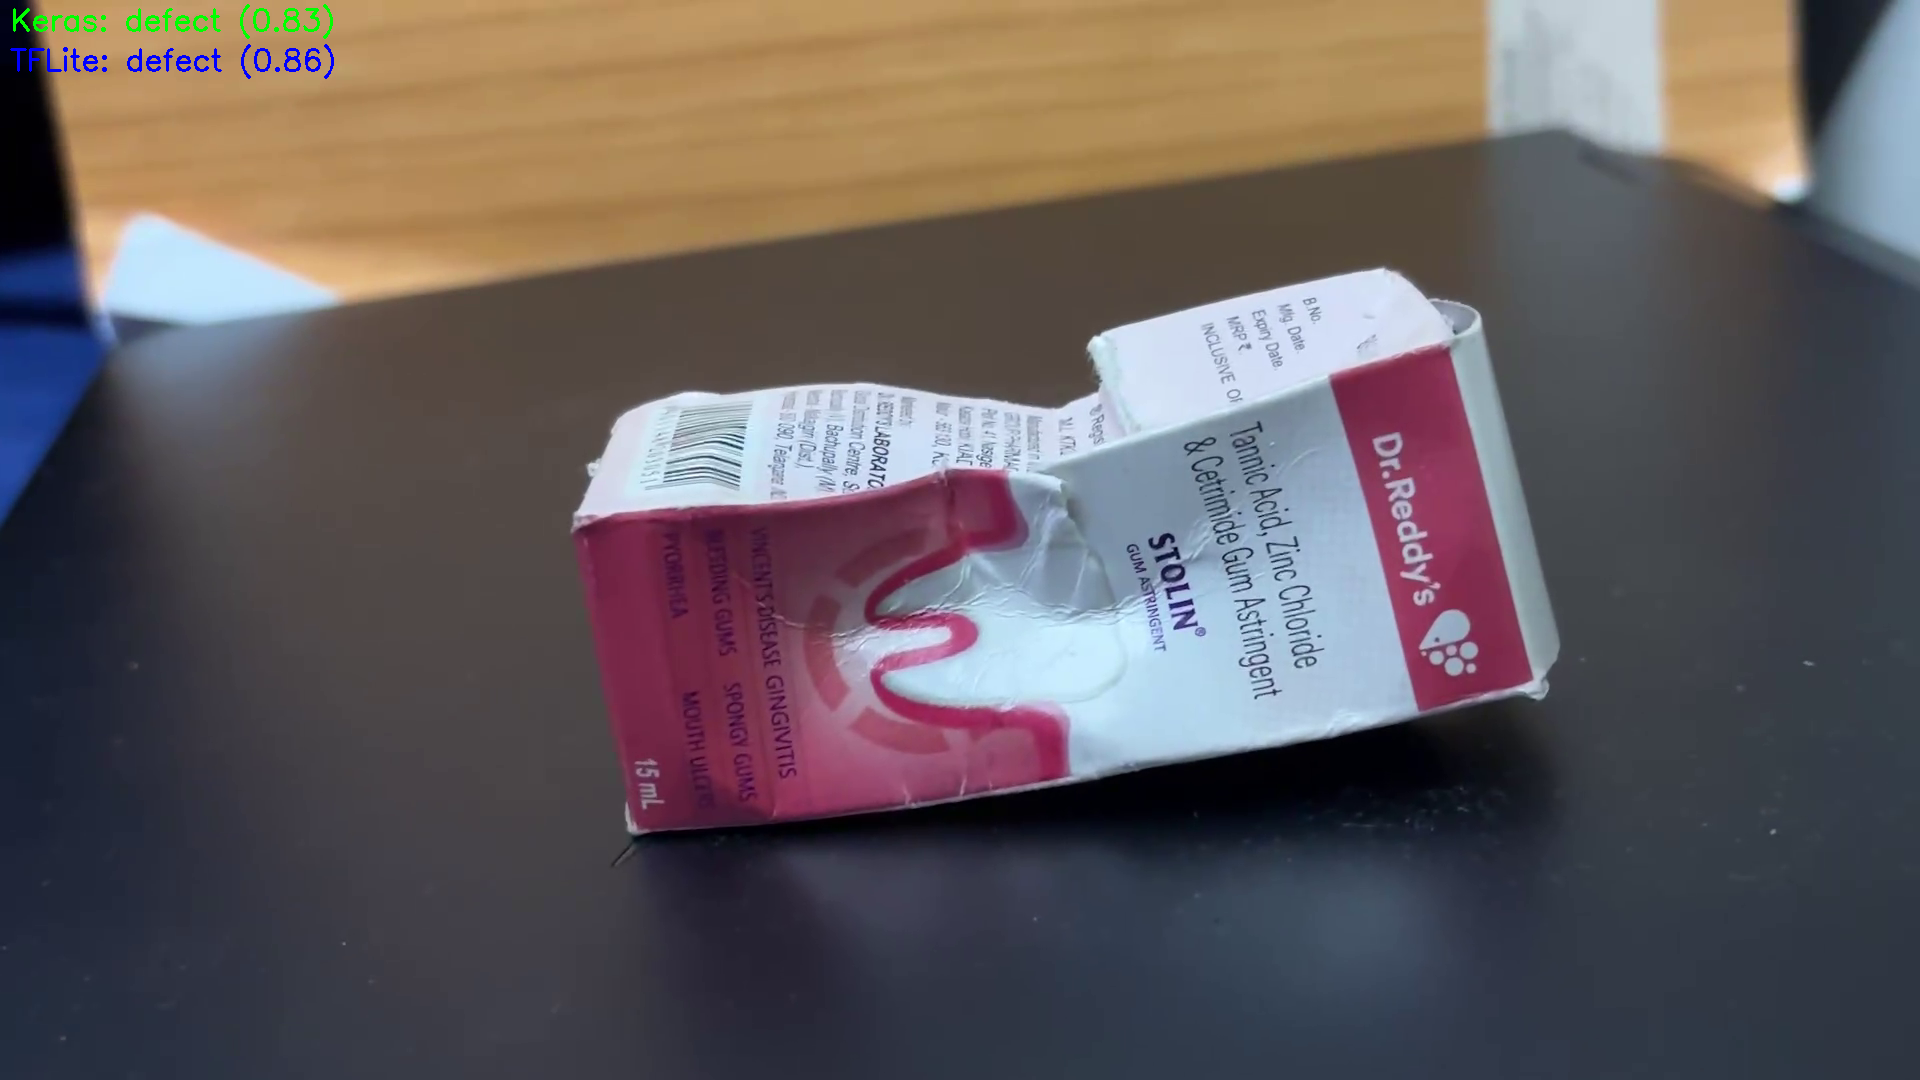

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from google.colab.patches import cv2_imshow
from IPython.display import display, clear_output
import ipywidgets as widgets
# Open the video file
video_path = "defect_video.mov"
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print(f"Error: Could not open video file {video_path}")
    exit()

# Create a widget to display the video
output_widget = widgets.Output()
display(output_widget)

while True:
    ret, frame = cap.read()
    if not ret:
        print("End of video stream or error reading frame.")
        break

    try:
        # Predict with Keras model
        predicted_class_keras, confidence_keras = predict_with_keras_model(model, frame)
        label_keras = f'Keras: {label_mapping[predicted_class_keras]} ({confidence_keras:.2f})'
        cv2.putText(frame, label_keras, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Predict with TensorFlow Lite model
        predicted_class_tflite, confidence_tflite = predict_with_tflite_model(interpreter, frame)
        label_tflite = f'TFLite: {label_mapping[predicted_class_tflite]} ({confidence_tflite:.2f})'
        cv2.putText(frame, label_tflite, (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

        # Display the frame using cv2_imshow
        with output_widget:
            clear_output(wait=True)
            cv2_imshow(frame)

    except Exception as e:
        print(f"Error processing frame: {str(e)}")
        continue

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [ ]:
#code of realtime
import cv2
import numpy as np
import tensorflow as tf

# Define label mapping
label_mapping = {0: 'intact', 1: 'defect'}

# Load the Keras model
keras_model_path = checkpoint_dir + '/final_model.h5'
keras_model = tf.keras.models.load_model(keras_model_path)

# Load the TensorFlow Lite model
tflite_model_path = checkpoint_dir + '/final_model.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()


# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def preprocess_frame(frame, target_size=(224, 224)):
    resized = cv2.resize(frame, target_size)
    rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
    normalized = rgb / 255.0
    normalized = normalized.astype(np.float32)
    return np.expand_dims(normalized, axis=0)

def predict_with_keras_model(model, frame):
    preprocessed = preprocess_frame(frame)
    predictions = model.predict(preprocessed)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0])
    return predicted_class, confidence

def predict_with_tflite_model(interpreter, frame):
    input_shape = input_details[0]['shape'][1:3]
    preprocessed = preprocess_frame(frame, target_size=input_shape)

    interpreter.set_tensor(input_details[0]['index'], preprocessed)
    interpreter.invoke()

    predictions = interpreter.get_tensor(output_details[0]['index'])
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0])
    return predicted_class, confidence



In [ ]:
#code of realtime
import cv2
import numpy as np
import tensorflow as tf
from google.colab.patches import cv2_imshow
from IPython.display import display, clear_output
import ipywidgets as widgets
# Open the video file
video_path = "video.mov"
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print(f"Error: Could not open video file {video_path}")
    exit()

# Create a widget to display the video
output_widget = widgets.Output()
display(output_widget)

while True:
    ret, frame = cap.read()
    if not ret:
        print("End of video stream or error reading frame.")
        break

    try:
        # Predict with Keras model
        predicted_class_keras, confidence_keras = predict_with_keras_model(model, frame)
        label_keras = f'Keras: {label_mapping[predicted_class_keras]} ({confidence_keras:.2f})'
        cv2.putText(frame, label_keras, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Predict with TensorFlow Lite model
        predicted_class_tflite, confidence_tflite = predict_with_tflite_model(interpreter, frame)
        label_tflite = f'TFLite: {label_mapping[predicted_class_tflite]} ({confidence_tflite:.2f})'
        cv2.putText(frame, label_tflite, (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

        # Display the frame using cv2_imshow
        with output_widget:
            clear_output(wait=True)
            cv2_imshow(frame)

    except Exception as e:
        print(f"Error processing frame: {str(e)}")
        continue

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Error: Could not open video file video.mov


Output()

End of video stream or error reading frame.
